### **Variational Autoencoders**

In an autoencoder, each image is mapped directly to one point in the latent space. In a variational autoencoder, each image is instead mapped to a multivariate normal distribution around a point in the latent space.

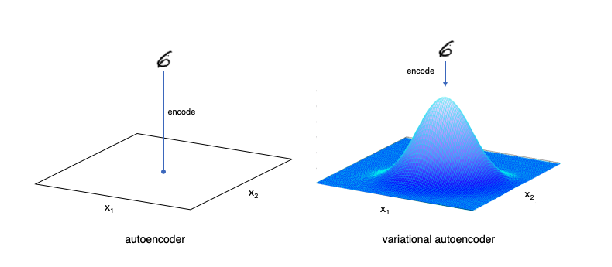

In [12]:
from IPython.display import Image
Image('aeVSvae.png')

Variational autoencoders assume that there is no correlation between any of the dimensions in the latent space and therefore that the covariance matrix is diagonal. This means the encoder only needs to map each input to a mean vector and a variance vector and does not need to worry about covariance between dimensions. We also choose to map to the logarithm of the variance, as this can take any real number in the range (– ∞, ∞), matching the natural output range from a neural network unit, whereas variance values are always positive.

To summarize, the encoder will take each input image and encode it to two vectors, mu and log_var which together define a multivariate normal distribution in the latent space:

mu
    The mean point of the distribution.

log_var
    The logarithm of the variance of each dimension.
   
To encode an image into a specific point z in the latent space, we can sample from this distribution, using the following equation:

    z = mu + sigma * epsilon

where
    
    sigma = exp(log_var / 2)
    
    epsilon is a point sampled from the standard normal distribution.

Relating this back to our story, mu represents Mr. N. Coder’s opinion of where the marker should appear on the wall. epsilon is his daughter’s random choice of how far away from mu the marker should be placed, scaled by sigma, Mr. N. Coder’s confidence in the marker’s position.
So why does this small change to the encoder help?

In Autoencoder, we saw how there was no requirement for the latent space to be continuous—even if the point (–2, 2) decodes to a well-formed image of a 4, there was no requirement for (–2.1, 2.1) to look similar. Now, since we are sampling a random point from an area around mu, the decoder must ensure that all points in the same neighborhood produce very similar images when decoded, so that the reconstruction loss remains small. This is a very nice property that ensures that even when we choose a point in the latent space that has never been seen by the decoder, it is likely to decode to an image that is well formed.

**Loss Function**

In Autoencoder, We had only RMSE error for calculating the loss. But in VAE, along with RMSE, there is another loss component added to VAE, KL Divergence.

KL divergence is a way of measuring how much one probability distribution differs from another. In a VAE, we want to measure how different our normal distribution with parameters mu and log_var is from the standard normal distribution. In this special case, the KL divergence has the closed form:

    kl_loss = -0.5 * sum(1 + log_var - mu ^ 2 - exp(log_var))

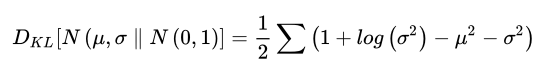

In [2]:
Image('kldivergence.png')

The sum is taken over all the dimensions in the latent space. kl_loss is minimized to 0 when mu = 0 and log_var = 0 for all dimensions. As these two terms start to differ from 0, kl_loss increases.

In summary, the KL divergence term penalizes the network for encoding observations to mu and log_var variables that differ significantly from the parameters of a standard normal distribution, namely mu = 0 and log_var = 0.

**Why does this addition to the loss function help?**

First, we now have a well-defined distribution that we can use for choosing points in the latent space—the standard normal distribution. If we sample from this distribution, we know that we’re very likely to get a point that lies within the limits of what the VAE is used to seeing. Secondly, since this term tries to force all encoded distributions toward the standard normal distribution, there is less chance that large gaps will form between point clusters. Instead, the encoder will try to use the space around the origin symmetrically and efficiently.

**In the code, the loss function for a VAE is simply the addition of the reconstruction loss and the KL divergence loss term. We weight the reconstruction loss with a term, r_loss_factor, that ensures that it is well balanced with the KL divergence loss. If we weight the reconstruction loss too heavily, the KL loss will not have the desired regulatory effect and we will see the same problems that we experienced with the plain autoencoder. If the weighting term is too small, the KL divergence loss will dominate and the reconstructed images will be poor. This weighting term is one of the parameters to tune when you’re training your VAE.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import os
from VAE import VariationalAutoencoder
import tensorflow as tf
from utils.loaders import load_mnist, load_model

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [3]:
def pixel_pos_value(image):
    pix_val_pos = {}
    for i, pix_val in enumerate(image.reshape(-1)):
        pix_val_pos[i]=pix_val
    return pix_val_pos

### **All Image Mean**

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


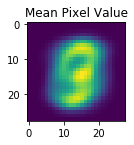

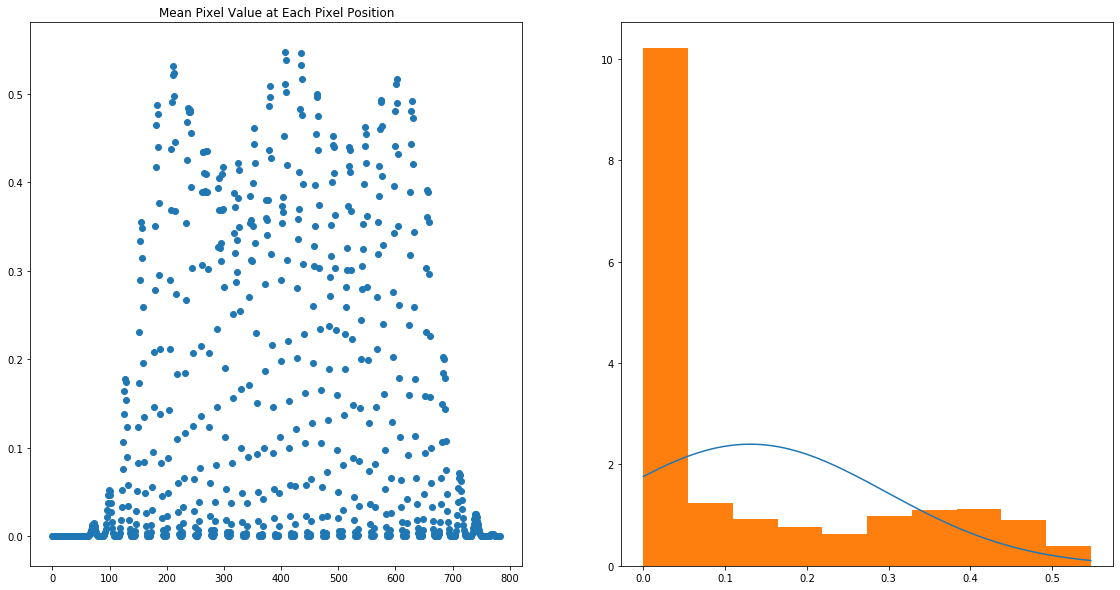

In [4]:
image = x_train.mean(axis=0).squeeze(-1)
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Mean Pixel Value")
plt.figure(figsize=(30,10))
plt.subplot(1,3,2)
pix_val_pos = pixel_pos_value(image)
plt.scatter(pix_val_pos.keys(), pix_val_pos.values())
plt.title("Mean Pixel Value at Each Pixel Position")
plt.subplot(1,3,3)
h = sorted(image.reshape(-1))
fit = stats.norm.pdf(h, np.mean(h), np.std(h))
plt.plot(h,fit)
plt.hist(h,normed=True)
plt.show()

### **Image of Zero Digit**

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app


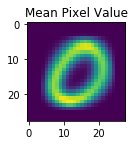

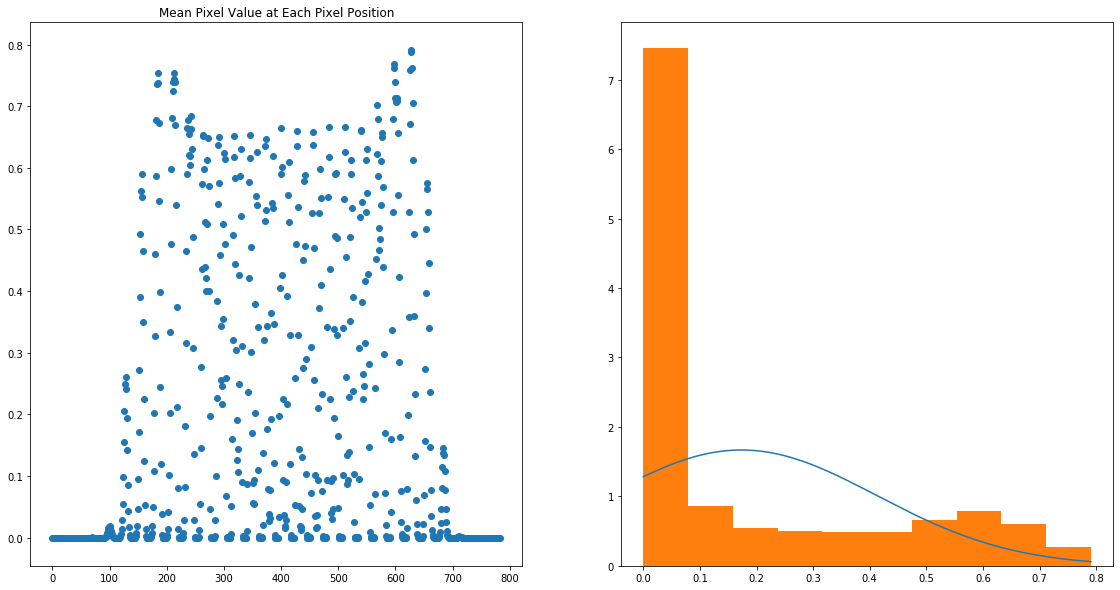

In [5]:
#x_train[np.where(y_train == 0)[0]]
image = x_train[np.where(y_train == 0)[0]].mean(axis=0).squeeze(-1)
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Mean Pixel Value")
plt.figure(figsize=(30,10))
plt.subplot(1,3,2)
pix_val_pos = pixel_pos_value(image)
plt.scatter(pix_val_pos.keys(), pix_val_pos.values())
plt.title("Mean Pixel Value at Each Pixel Position")
plt.subplot(1,3,3)
h = sorted(image.reshape(-1))
fit = stats.norm.pdf(h, np.mean(h), np.std(h))
plt.plot(h,fit)
plt.hist(h,normed=True)
plt.show()

### **Image of One Digit**

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app


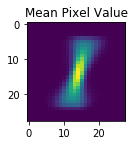

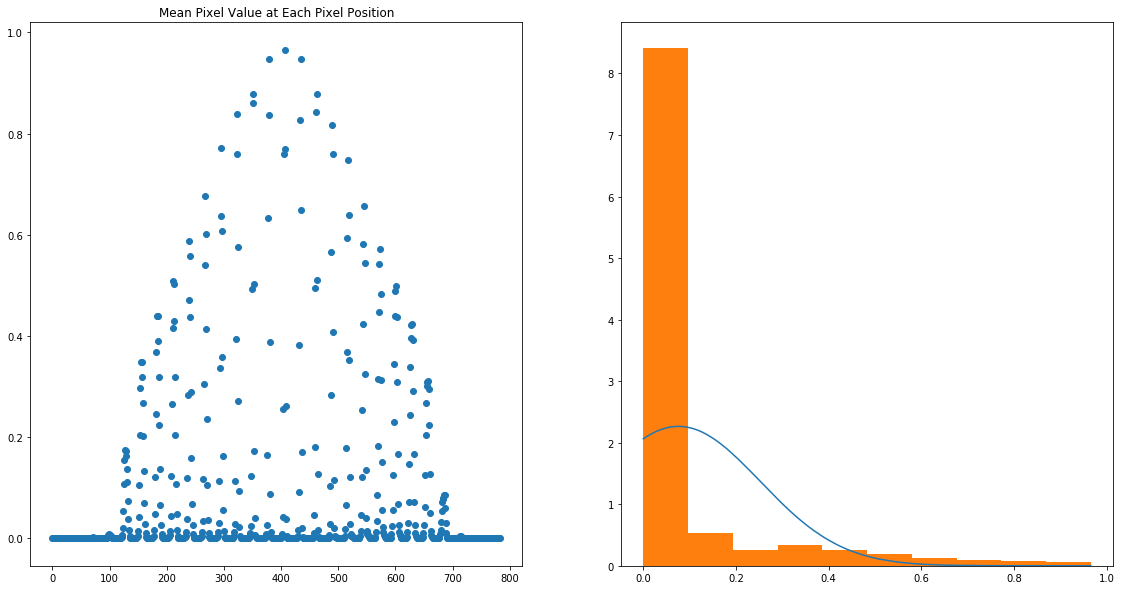

In [6]:
#x_train[np.where(y_train == 0)[0]]
image = x_train[np.where(y_train == 1)[0]].mean(axis=0).squeeze(-1)
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Mean Pixel Value")
plt.figure(figsize=(30,10))
plt.subplot(1,3,2)
pix_val_pos = pixel_pos_value(image)
plt.scatter(pix_val_pos.keys(), pix_val_pos.values())
plt.title("Mean Pixel Value at Each Pixel Position")
plt.subplot(1,3,3)
h = sorted(image.reshape(-1))
fit = stats.norm.pdf(h, np.mean(h), np.std(h))
plt.plot(h,fit)
plt.hist(h,normed=True)
plt.show()

### **Image of Eight Digit**

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


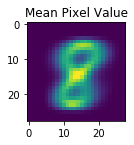

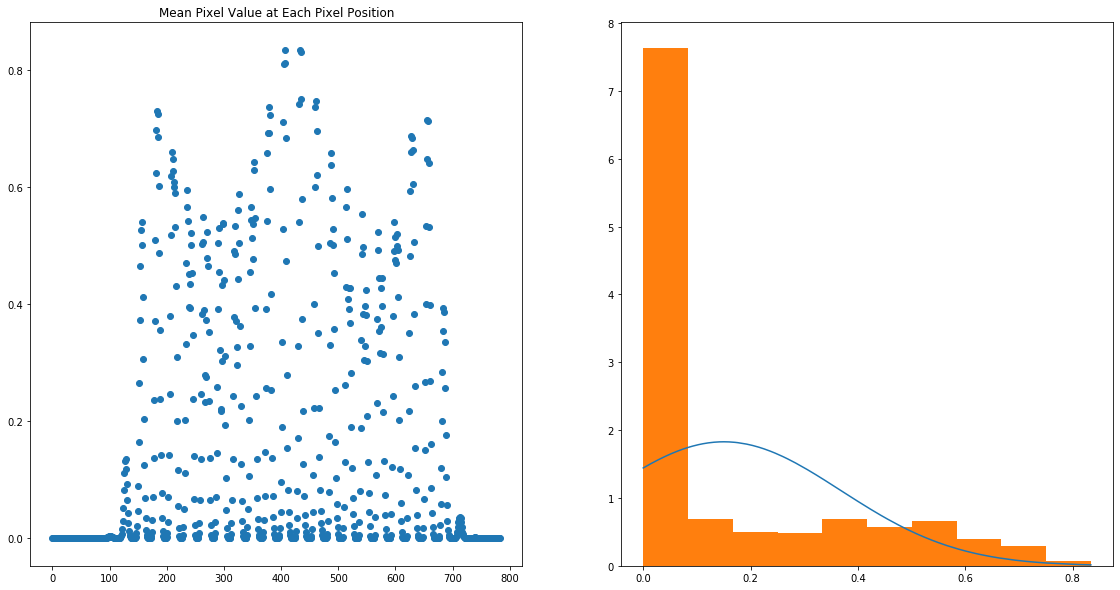

In [7]:
image = x_train[np.where(y_train == 8)[0]].mean(axis=0).squeeze(-1)
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Mean Pixel Value")
plt.figure(figsize=(30,10))
plt.subplot(1,3,2)
pix_val_pos = pixel_pos_value(image)
plt.scatter(pix_val_pos.keys(), pix_val_pos.values())
plt.title("Mean Pixel Value at Each Pixel Position")
plt.subplot(1,3,3)
h = sorted(image.reshape(-1))
fit = stats.norm.pdf(h, np.mean(h), np.std(h))
plt.plot(h,fit)
plt.hist(h,normed=True)
plt.show()

In [5]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [6]:
vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

(None, 3136)


In [7]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

In [8]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [9]:
BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [ ]:
vae.train(     
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/200
32/32 [==============================] - ETA: 0s - loss: 0.0000e+00 - vae_r_loss: 230.8528 - vae_kl_loss: 0.0000e+00
Epoch 00001: saving model to run/vae/0002_digits/weights/weights.h5
32/32 [==============================] - 3s 85ms/step - loss: 0.0000e+00 - vae_r_loss: 230.8528 - vae_kl_loss: 0.0000e+00
Epoch 2/200
32/32 [==============================] - ETA: 0s - loss: 0.0000e+00 - vae_r_loss: 230.8460 - vae_kl_loss: 0.0000e+00
Epoch 00002: saving model to run/vae/0002_digits/weights/weights.h5
32/32 [==============================] - 3s 86ms/step - loss: 0.0000e+00 - vae_r_loss: 230.8460 - vae_kl_loss: 0.0000e+00
Epoch 3/200
32/32 [==============================] - ETA: 0s - loss: 0.0000e+00 - vae_r_loss: 230.8597 - vae_kl_loss: 0.0000e+00
Epoch 00003: saving model to run/vae/0002_digits/weights/weights.h5
32/32 [==============================] - 3s 87ms/step - loss: 0.0000e+00 - vae_r_loss: 230.8597 - vae_kl_loss: 0.0000e+00
Epoch 4/200
32/32 [========================

In [10]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

(None, 3136)


(10, 28, 28, 1)


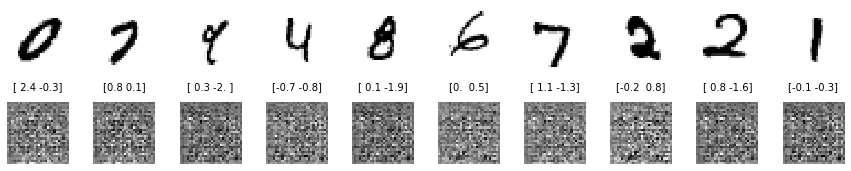

In [13]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
print(example_images.shape)

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

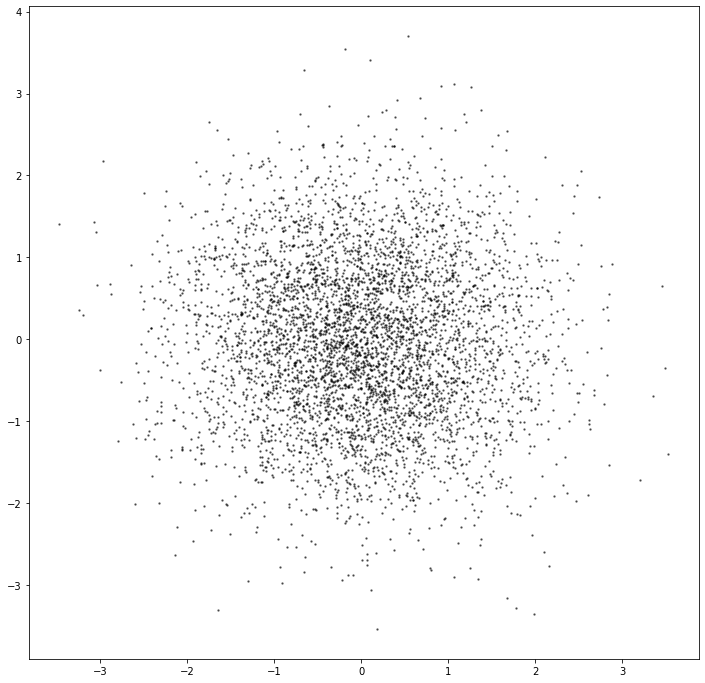

In [23]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

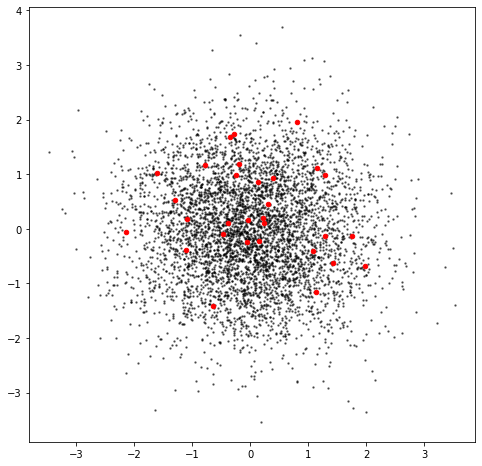

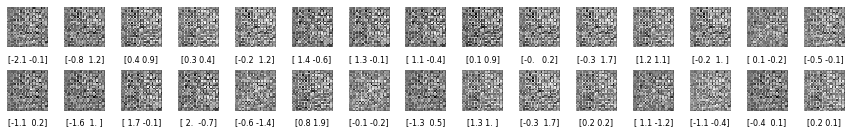

In [24]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')


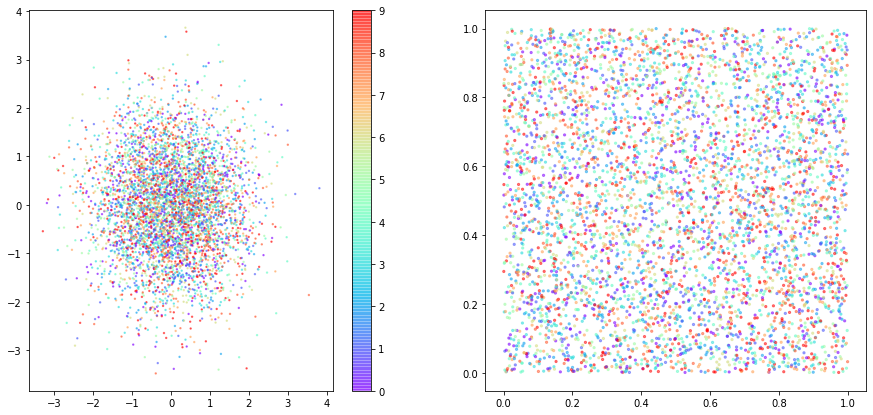

In [25]:
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

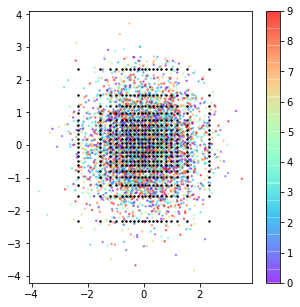

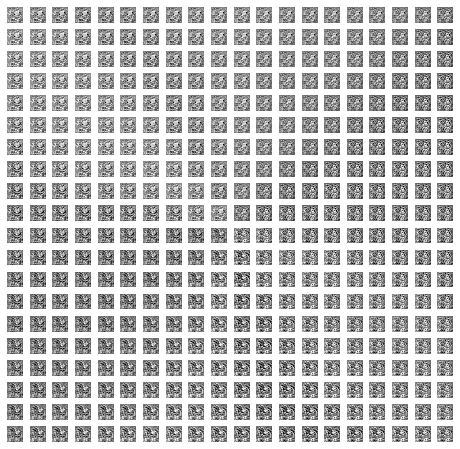

In [26]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')
